# Homework07

Exercises to practice pandas, data analysis and classification

## Goals

- Understand the effects of pre-processing data
- Get familiar with the ML flow: encode -> normalize -> train -> evaluate
- Understand the difference between regression and classification tasks
- Build an intuition for different classification models

### Setup

Run the following 2 cells to import all necessary libraries and helpers for this homework.

In [32]:
!wget -q https://github.com/PSAM-5020-2025S-A/5020-utils/raw/main/src/data_utils.py
!wget -q https://github.com/PSAM-5020-2025S-A/5020-utils/raw/main/src/image_utils.py

!wget -qO- https://github.com/PSAM-5020-2025S-A/5020-utils/releases/latest/download/0801-500.tar.gz | tar xz

In [33]:
import pandas as pd
import PIL.Image as PImage

from os import listdir, path

from data_utils import RandomForestClassifier, SVC
from data_utils import classification_error, display_confusion_matrix, regression_error

from image_utils import get_pixels, make_image

from Homework07_utils import CamUtils

## Classification

The dataset we are going to use has images from $25$ different security cameras, and our task is to separate them by camera. Some of the cameras move, some of them don't, and there are more than $1000$ images, so there's no way we want to do this by hand.

### Loading Data

If we look at the images in `./data/image/0801-500/train/`, we'll notice that they are named and organized in a very particular way. They're all in the same directory and the first part of their filename specifies which camera they came from. Even though those `ids` are numbers, they're not sequential, so we'll use some helper functions to extract a unique `label` from their filenames.

This is exactly what the `OrdinalEncoder` class does, but since we only have to encode this one column, we'll do it by hand while we read the files in.

In [34]:
# this creates a list of all the files in a given directory, that end in .jpg
train_files = [f for f in listdir("./data/image/0801-500/train") if f.endswith(".jpg")]

In [35]:
# TODO: check and see what is inside the list here
print(train_files)

['17-66.jpg', '28-27.jpg', '01-40.jpg', '03-79.jpg', '01-17.jpg', '23-07.jpg', '05-22.jpg', '08-50.jpg', '13-52.jpg', '07-01.jpg', '26-04.jpg', '26-35.jpg', '03-78.jpg', '09-62.jpg', '19-30.jpg', '03-23.jpg', '07-11.jpg', '08-27.jpg', '09-48.jpg', '08-21.jpg', '07-12.jpg', '02-36.jpg', '19-84.jpg', '18-57.jpg', '08-52.jpg', '26-61.jpg', '13-09.jpg', '10-50.jpg', '22-53.jpg', '23-60.jpg', '09-04.jpg', '23-41.jpg', '02-40.jpg', '28-67.jpg', '12-30.jpg', '17-81.jpg', '19-17.jpg', '24-50.jpg', '22-43.jpg', '12-32.jpg', '03-67.jpg', '13-56.jpg', '12-19.jpg', '03-69.jpg', '22-00.jpg', '11-25.jpg', '22-42.jpg', '02-06.jpg', '03-13.jpg', '05-30.jpg', '26-29.jpg', '07-85.jpg', '13-10.jpg', '24-10.jpg', '31-08.jpg', '21-60.jpg', '03-36.jpg', '17-10.jpg', '13-21.jpg', '02-14.jpg', '28-62.jpg', '01-07.jpg', '31-11.jpg', '28-17.jpg', '11-04.jpg', '22-38.jpg', '27-47.jpg', '10-48.jpg', '17-90.jpg', '15-38.jpg', '27-08.jpg', '22-48.jpg', '11-48.jpg', '05-25.jpg', '26-62.jpg', '12-21.jpg', '21-15.jpg'

Now we'll read the image pixels and extract their labels. `CamUtils.get_label()` is the helper function we'll use to "encode" and return a label id based on the filename.

In [36]:
pixel_data = []
label_data = []

for fname in train_files:
  label = CamUtils.get_label(fname)
  img = PImage.open(path.join("./data/image/0801-500/train", fname))
  pixel_data.append(get_pixels(img))
  label_data.append(label)

In [37]:
# TODO: check if labels got extracted correctly by looking at 
#       the first few items of the label list and the filename list
print(label_data[:5])
print(train_files[:5])

[13, 23, 0, 2, 0]
['17-66.jpg', '28-27.jpg', '01-40.jpg', '03-79.jpg', '01-17.jpg']


The labels and the filenames won't match exactly since labels start at $0$ and the filenames start at $01$ and skip some numbers.

We can open some images from pixels, just to make sure we loaded them correctly:

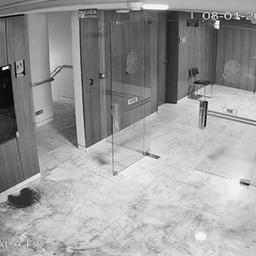

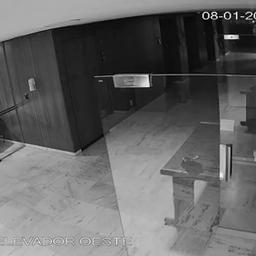

In [38]:
display(make_image(pixel_data[0]))
display(make_image(pixel_data[10]))

And now might not be a bad time to peek into the `data/image/0801-500/` directories to see what's inside them and what the images look like.... and get to know the data...

### DataFrame it

Let's put our raw pixel data into a `DataFrame`, and create a column for storing each image's label.

(this next cell might take a while to run)

In [39]:
train_df = pd.DataFrame(pixel_data)
train_df["label"] = label_data

Let's inspect our `DataFrame`:

In [40]:
train_df.head()

,0,1,2,3,4,5,6,7,8,9,...,65527,65528,65529,65530,65531,65532,65533,65534,65535,label
0,117,119,120,121,120,118,115,113,116,116,...,205,200,201,203,204,204,203,202,201,13
1,86,86,86,85,85,85,84,84,85,85,...,100,97,97,96,95,93,94,96,98,23
2,82,82,82,83,84,85,87,87,87,87,...,36,34,33,31,30,30,31,33,34,0
3,0,0,0,0,0,0,0,0,0,0,...,2,3,3,2,1,1,0,0,0,2
4,199,199,199,199,199,199,199,199,200,200,...,75,77,77,77,78,78,79,79,79,0


In [41]:
train_df.isna().sum().sum()

np.int64(0)

### Insight

<span style="color:hotpink">
Does anything stand out as peculiar about the feature values in our <code>DataFrame</code>?<br>
Do we have to encode or scale our data?<br>
Why? Or, why not?<br>
</span>

<span style="color:yellow;">
Scaling is not required as the pixel values are in the same range, 0-255.

Encoding is not required as there is no qualitative value in the dataframe.

There is no NaN values.</span>

### Test Files

If that worked, repeat the process for the test files inside the `./data/image/0801-500/test/` directory.

We can almost use the exact same steps as we did above to create a `DataFrame`, the only difference being that we don't have labels for these images.

In [42]:
# TODO: create a list of files in the test/ directory
test_files = [f for f in listdir("./data/image/0801-500/test") if f.endswith(".jpg")]

# TODO: check its length and content
print(len(test_files))
print(test_files)

test_pixel_data = []

# TODO: loop over files and load their pixels into a list
for fname in test_files:
  img = PImage.open(path.join("./data/image/0801-500/test", fname))
  test_pixel_data.append(get_pixels(img))

# TODO: load into DataFrame (this might take 20 - 30 seconds)
test_df = pd.DataFrame(test_pixel_data)

1573
['14988432.jpg', '5592165.jpg', '11093418.jpg', '9283265.jpg', '13904397.jpg', '7739928.jpg', '13479893.jpg', '7458003.jpg', '6404325.jpg', '9290985.jpg', '12219053.jpg', '8220592.jpg', '8543611.jpg', '13464650.jpg', '9733942.jpg', '7982251.jpg', '7792212.jpg', '5784261.jpg', '6898947.jpg', '8873466.jpg', '8243216.jpg', '14766743.jpg', '13570821.jpg', '15034679.jpg', '16032745.jpg', '11590025.jpg', '10387542.jpg', '10972659.jpg', '12569433.jpg', '15677841.jpg', '14803978.jpg', '8121966.jpg', '8119438.jpg', '13832059.jpg', '10354550.jpg', '10032152.jpg', '6005832.jpg', '6593025.jpg', '5690715.jpg', '11102079.jpg', '12681086.jpg', '15977215.jpg', '15770408.jpg', '5797617.jpg', '10513891.jpg', '10329950.jpg', '9195185.jpg', '12394689.jpg', '15615310.jpg', '8502292.jpg', '14910193.jpg', '8540171.jpg', '11989901.jpg', '8621057.jpg', '9246565.jpg', '15602712.jpg', '12526954.jpg', '11838026.jpg', '12710918.jpg', '15087984.jpg', '7117954.jpg', '16270909.jpg', '12797500.jpg', '16324208.jpg

Check the `DataFrame`

In [43]:
test_df.head()

,0,1,2,3,4,5,6,7,8,9,...,65526,65527,65528,65529,65530,65531,65532,65533,65534,65535
0,55,60,51,59,63,62,72,67,65,69,...,83,84,79,83,87,88,84,80,78,78
1,57,58,60,62,66,69,72,74,71,72,...,185,191,197,193,189,186,185,185,184,183
2,41,46,39,23,20,31,38,34,31,33,...,80,83,87,81,75,75,78,78,74,70
3,173,172,164,168,203,246,255,237,249,253,...,173,181,175,168,160,166,175,165,157,165
4,188,188,188,188,188,188,188,188,185,185,...,178,180,175,180,186,187,184,180,179,180


Looks like data!!

We could train a `RandomForestClassifier` directly on this `DataFrame` and see what would happen, but my guess is that Python runs out of memory and crashes our tab/browser/computer...

We'll use _projection_ to reduce the number of dimensions in our dataset. Projection is when we just drop some of the columns in our dataset. 

Which columns ? That's up to us.

Let's first try using the first $N$ columns/features where $N$ is a number around $10$.

This is how we get the first $N$ columns from a `DataFrame`:

In [44]:
# split input and output features
NUM_FEATURES = 30
chosen_columns = train_df.columns[:NUM_FEATURES]
train_features = train_df[chosen_columns]

out_features = train_df["label"]

# also separate test dataset features
test_features = test_df[chosen_columns]

From our [Week 07](https://github.com/PSAM-5020-2025S-A/WK07) notebook, we can create a classification model by following these steps:

1. Load dataset (done! 🎉)
2. Encode label features as numbers (not needed! done! ⚡️)
3. Normalize the data (not needed! done! 🍾)
4. Separate the outcome variable and the input features (done! ☀️)
5. Create a model using chosen features
6. Run model on training data and measure error*
7. Run model on test data, measure error*, plot predictions, interpret results

We could use the same `regression_error()` function we used above to measure the error of our classifier model, but this could lead to $2$ issues. First, we don't have labels for the images in the test dataset, and second, the regression error reported might be higher than it actually is because an image with label $0$ that gets mislabeled as $5$ will count as being more wrong than if it was mislabeled $2$. And we don't want that. We just want to get the percentage of classifications that our model gets correctly.

To simplify calculating the classification accuracy we can use the `CamUtils.classification_accuracy()` function. This function takes $2$ parameters, a list of files and a list of predictions. It will work with the test and train datasets and will calculate a more meaningful accuracy value than the one returned by `regression_error()`.

In [45]:
# TODO: create a brand new classifier
mod = RandomForestClassifier()

# TODO: fit the model
mod.fit(train_features, out_features)

# TODO: run predictions
train_predictions = mod.predict(train_features)

# TODO: measure classification accuracy
CamUtils.classification_accuracy(train_files, train_predictions)

1.0

That should look promising. Let's run this on our test dataset.

Remember we already separated the test data features into a variable called `test_features` above.

Now we just have to run the prediction and measure accuracy.

In [46]:
# TODO: run predictions on test data
test_predictions = mod.predict(test_features)

# TODO: measure classification accuracy
CamUtils.classification_accuracy(test_files, test_predictions)

0.7628734901462174

In [47]:
# SVC
# TODO: create a brand new classifier
mod2 = SVC()

# TODO: fit the model
mod2.fit(train_features, out_features)

# TODO: run predictions
train_predictions2 = mod2.predict(train_features)

# TODO: measure classification accuracy
CamUtils.classification_accuracy(train_files, train_predictions2)

0.952

In [48]:
# TODO: run predictions on test data
test_predictions2 = mod2.predict(test_features)

# TODO: measure classification accuracy
CamUtils.classification_accuracy(test_files, test_predictions2)

0.7069294342021615

In [49]:
from sklearn.linear_model import LogisticRegression

# logistic regression
# TODO: create a brand new classifier
mod3 = LogisticRegression()

# TODO: fit the model
mod3.fit(train_features, out_features)

# TODO: run predictions
test_predictions3 = mod3.predict(train_features)

# TODO: measure classification accuracy
CamUtils.classification_accuracy(train_files, test_predictions3)

/home/vscode/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.676

In [50]:
# TODO: run predictions on test data
test_predictions3 = mod3.predict(test_features)

# TODO: measure classification accuracy
CamUtils.classification_accuracy(test_files, test_predictions3)

0.6160203432930705

### Interpretation

Using just the first $10$ pixels of the image the classifier is able to label most of the images correctly.

<span style="color:hotpink">
How can we improve this classifier? How does the number of features affect the classification accuracy of the test data<br>
How does the choice of pixels affect the accuracy?<br><br>
If you're curious, repeat the modeling above, but using the <code>SVC</code> classifier instead of <code>RandomForest</code>.<br>How does the choice of modeling technique affect the accuracy?<br><br>
Experiment with some of these parameters and explain your findings below.
</span>

<span style="color:yellow;">
The greater the number of features, the greater the classification accuracy.

The choice of pixels that capture the main bulk of the contents on the cctv are more likely to classify the images more accurately.


In this dataset, SVC and logistic regression had lower accuracy compared to RandomForest. 
After increasing the NUM_FEATURES from 10 to 30, the accuracy of the classification through RandomForest increase from 0.6007628734901462 to 0.7628734901462174!
</span>